In [173]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
from wordcloud import WordCloud
import networkx as nx

df = pd.read_csv('data/opportunities.csv',low_memory=False)
df = df.rename(columns={"Source ": "Source"})
df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [174]:
df.columns

Index(['ID', 'Region', 'Territory', 'Pricing, Delivery_Terms_Quote_Appr',
       'Pricing, Delivery_Terms_Approved', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval',
       'Bureaucratic_Code', 'Account_Created_Date', 'Source',
       'Billing_Country', 'Account_Name', 'Opportunity_Name', 'Opportunity_ID',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Account_Type', 'Opportunity_Type', 'Quote_Type', 'Delivery_Terms',
       'Opportunity_Created_Date', 'Brand', 'Product_Type', 'Size',
       'Product_Category_B', 'Price', 'Currency', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currency

In [175]:
#funcion para calcular la conversion a dolar
def conversion(x):
    if (x["Total_Taxable_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Taxable_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None
    
#funcion para calcular la conversion a dolar
def conversion_item(x):
    if (x["Total_Amount_Currency"] == "USD"):
        return 1
    elif (x["Total_Amount_Currency"] == x["ASP_Currency"] and float(x["ASP"]) != 0):  
        return x["ASP_(converted)"] / float(x["ASP"])
    else:
        return None

In [176]:
#creo condicion donde para filtrar registros donde no tenga manera de convertir a moneda el total taxeable
condition_total_taxable_amount = (df['Total_Taxable_Amount_Currency'] != df['Total_Amount_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Taxable_Amount_Currency'] != df['ASP_(converted)_Currency'])

condition_total_amount = (df['Total_Amount_Currency'] != df['ASP_Currency'])\
& (df['Total_Amount_Currency'] != df['ASP_(converted)_Currency'])

In [177]:
df_amount = df.loc[:,['Price','Currency','Total_Amount','Total_Amount_Currency','ASP','ASP_Currency','ASP_(converted)','ASP_(converted)_Currency','Total_Taxable_Amount','Total_Taxable_Amount_Currency']]
df_amount.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price                          16947 non-null  object 
 1   Currency                       16947 non-null  object 
 2   Total_Amount                   16888 non-null  float64
 3   Total_Amount_Currency          16947 non-null  object 
 4   ASP                            13738 non-null  float64
 5   ASP_Currency                   16947 non-null  object 
 6   ASP_(converted)                13738 non-null  float64
 7   ASP_(converted)_Currency       16947 non-null  object 
 8   Total_Taxable_Amount           16947 non-null  float64
 9   Total_Taxable_Amount_Currency  16947 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.3+ MB


In [178]:
df_amount["Price"] = pd.to_numeric(df_amount["Price"],errors='coerce')
df_amount["Total_Amount"] = pd.to_numeric(df_amount["Total_Amount"],errors='coerce')
df_amount["ASP"] = pd.to_numeric(df_amount["ASP"],errors='coerce')
df_amount["ASP_(converted)"] = pd.to_numeric(df_amount["ASP_(converted)"],errors='coerce')
df_amount["Total_Taxable_Amount"] = pd.to_numeric(df_amount["Total_Taxable_Amount"],errors='coerce')
df_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Price                          356 non-null    float64
 1   Currency                       16947 non-null  object 
 2   Total_Amount                   16888 non-null  float64
 3   Total_Amount_Currency          16947 non-null  object 
 4   ASP                            13738 non-null  float64
 5   ASP_Currency                   16947 non-null  object 
 6   ASP_(converted)                13738 non-null  float64
 7   ASP_(converted)_Currency       16947 non-null  object 
 8   Total_Taxable_Amount           16947 non-null  float64
 9   Total_Taxable_Amount_Currency  16947 non-null  object 
dtypes: float64(5), object(5)
memory usage: 1.3+ MB


In [179]:
df_show_amount = df_amount.count().to_frame().reset_index()
df_show_amount.columns = ["Columna","Cantidad de Registros con datos validos"]
df_show_amount

,Columna,Cantidad de Registros con datos validos
0,Price,356
1,Currency,16947
2,Total_Amount,16888
3,Total_Amount_Currency,16947
4,ASP,13738
5,ASP_Currency,16947
6,ASP_(converted),13738
7,ASP_(converted)_Currency,16947
8,Total_Taxable_Amount,16947
9,Total_Taxable_Amount_Currency,16947


In [180]:
colorscale = [[0, '#91860d'],[.5, '#d6cc5a'],[1, '#f5efb0']]
table = ff.create_table(df_show_amount,colorscale=colorscale)
#py.iplot(table)

In [181]:
df_geografic = df.loc[:,["Region","Territory","Billing_Country"]]
df_geografic["Territory"] = df_geografic["Territory"].replace("None",np.NaN)
df_geografic["Region"] = df_geografic["Region"].replace("None",np.NaN)
df_geografic["Billing_Country"] = df_geografic["Billing_Country"].replace("None",np.NaN)
df_geografic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Region           16947 non-null  object
 1   Territory        11948 non-null  object
 2   Billing_Country  16920 non-null  object
dtypes: object(3)
memory usage: 397.3+ KB


In [182]:
df_geografic_show = df_geografic.count().to_frame().reset_index()
df_geografic_show.columns = ["Columna","Cantidad de Registros con datos validos"]
df_geografic_show

,Columna,Cantidad de Registros con datos validos
0,Region,16947
1,Territory,11948
2,Billing_Country,16920


In [183]:
colorscale = [[0, '#4d004c'],[.5, '#f2e5ff'],[1, '#ffffff']]
table = ff.create_table(df_geografic_show,colorscale=colorscale)
#py.iplot(table)

In [184]:
df_categoric = df.loc[:,["Source","Opportunity_Type","Quote_Type","Delivery_Terms","Brand","Product_Type","Size",\
                         "Product_Family","Product_Name","Prod_Category_A","Product_Category_B","Stage"]]

df_categoric["Source"] = df_categoric["Source"].replace("None",np.NaN)
df_categoric["Opportunity_Type"] = df_categoric["Opportunity_Type"].replace("None",np.NaN)
df_categoric["Quote_Type"] = df_categoric["Quote_Type"].replace("None",np.NaN)
df_categoric["Delivery_Terms"] = df_categoric["Delivery_Terms"].replace("None",np.NaN)
df_categoric["Brand"] = df_categoric["Brand"].replace("None",np.NaN)
df_categoric["Product_Type"] = df_categoric["Product_Type"].replace("None",np.NaN)
df_categoric["Size"] = df_categoric["Size"].replace("None",np.NaN)
df_categoric["Product_Family"] = df_categoric["Product_Family"].replace("None",np.NaN)
df_categoric["Product_Name"] = df_categoric["Product_Name"].replace("None",np.NaN)
df_categoric["Prod_Category_A"] = df_categoric["Prod_Category_A"].replace("None",np.NaN)
df_categoric["Product_Category_B"] = df_categoric["Product_Category_B"].replace("None",np.NaN)
df_categoric["Stage"] = df_categoric["Stage"].replace("None",np.NaN)
df_categoric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Source              7450 non-null   object
 1   Opportunity_Type    16947 non-null  object
 2   Quote_Type          16947 non-null  object
 3   Delivery_Terms      16947 non-null  object
 4   Brand               1036 non-null   object
 5   Product_Type        1012 non-null   object
 6   Size                980 non-null    object
 7   Product_Family      16947 non-null  object
 8   Product_Name        16947 non-null  object
 9   Prod_Category_A     16947 non-null  object
 10  Product_Category_B  1019 non-null   object
 11  Stage               16947 non-null  object
dtypes: object(12)
memory usage: 1.6+ MB


In [185]:
df_categoric_show = df_categoric.count().to_frame().reset_index()
df_categoric_show.columns = ["Columna","Cantidad de Registros con datos validos"]
df_categoric_show

,Columna,Cantidad de Registros con datos validos
0,Source,7450
1,Opportunity_Type,16947
2,Quote_Type,16947
3,Delivery_Terms,16947
4,Brand,1036
5,Product_Type,1012
6,Size,980
7,Product_Family,16947
8,Product_Name,16947
9,Prod_Category_A,16947


In [186]:
colorscale = [[0, '#0c8c06'],[.5, '#65d95f'],[1, '#d7f5d5']]
table = ff.create_table(df_categoric_show,colorscale=colorscale)
#py.iplot(table)

In [187]:
df_item_amount = df.loc[condition_total_amount!= True,:]
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [188]:
df_item_amount["convertion"] = df_item_amount.apply(conversion_item, axis=1)
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000


In [189]:
#Convierto el total tax amount a moneda dolar para poder comparar
df_item_amount["Total Item Amount (USD)"] = df_item_amount["Total_Amount"] * df_item_amount["convertion"]
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion,Total Item Amount (USD)
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096,5964043.80
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094,54552.68
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,83865.60
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000,7421881.50
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,13357192.50


In [190]:
df_currency_show = df_item_amount["Total_Amount_Currency"].value_counts().to_frame().reset_index()
df_currency_show.columns = ["Total_Amount_Currency","Count"]
df_currency_show

,Total_Amount_Currency,Count
0,USD,7361
1,JPY,4522
2,EUR,4503
3,AUD,556
4,GBP,5


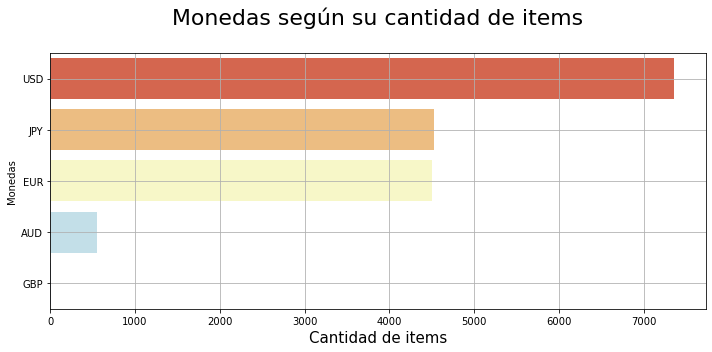

In [191]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_currency_show,x='Count',y='Total_Amount_Currency',palette="RdYlBu")
plt.grid(True)
plt.xlabel('Cantidad de items',size=15)
plt.ylabel('Monedas')
plt.title('Monedas según su cantidad de items\n',size=22)
plt.tight_layout()
#plt.savefig("pngs/Items-moneda.png")

In [192]:
df_item_amount_aux = df_item_amount.loc[:,["ID","Product_Name","Stage","Total Item Amount (USD)"]]
df_item_amount_show_loss = df_item_amount_aux[df_item_amount_aux["Stage"] == "Closed Lost"].nlargest(10,"Total Item Amount (USD)")
df_item_amount_show_won = df_item_amount_aux[df_item_amount_aux["Stage"] == "Closed Won"].nlargest(10,"Total Item Amount (USD)")
df_final_show = df_item_amount_show_won.append(df_item_amount_show_loss).sort_values("Total Item Amount (USD)",ascending=False)
df_final_show

,ID,Product_Name,Stage,Total Item Amount (USD)
16682,21007,Product_Name_307,Closed Lost,3.150001e+08
16616,28458,Product_Name_307,Closed Lost,2.562015e+08
2179,10808,Product_Name_110,Closed Lost,2.445877e+08
7364,14461,Product_Name_411,Closed Lost,1.587382e+08
3667,8037,Product_Name_98,Closed Lost,1.539788e+08
2806,4909,Product_Name_32,Closed Lost,1.237501e+08
16317,19642,Product_Name_307,Closed Lost,1.023999e+08
16409,23987,Product_Name_307,Closed Lost,9.600192e+07
16408,23984,Product_Name_307,Closed Lost,9.600192e+07
2298,18169,Product_Name_307,Closed Lost,9.449991e+07


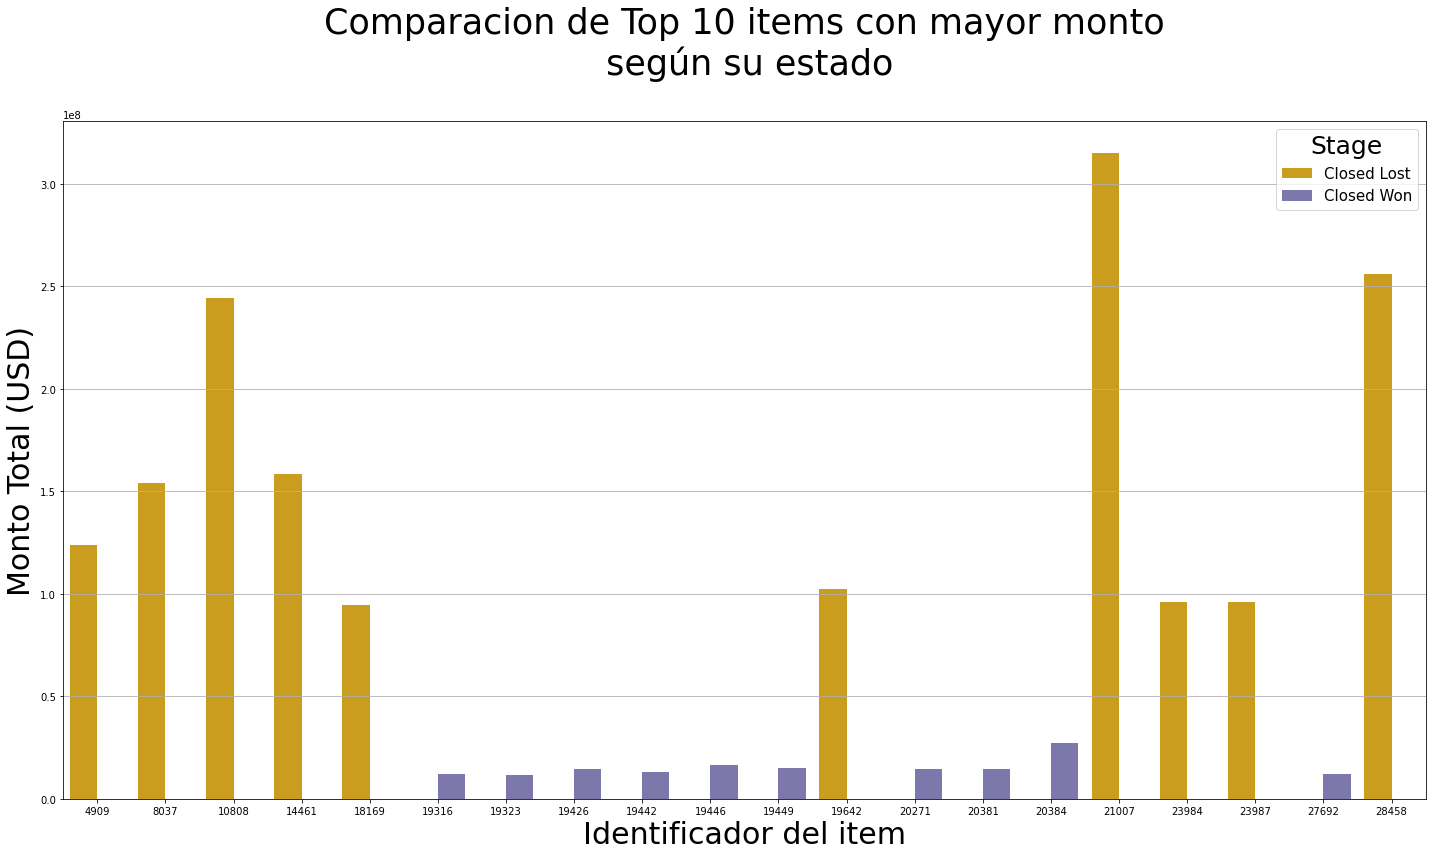

In [193]:
fig,ax=plt.subplots(figsize=(20,12))
plt.grid(True)
g = sns.barplot(ax=ax,data=df_final_show,x='ID',y='Total Item Amount (USD)',palette='Dark2_r',hue='Stage')
g.set_title('Comparacion de Top 10 items con mayor monto\n según su estado\n',size=35)
g.set_xlabel('Identificador del item',size=30)
g.set_ylabel('Monto Total (USD)',size=30)
g.legend(title='Stage',fontsize = '15',title_fontsize='25',loc='upper right')
plt.tight_layout()
#plt.savefig("pngs/Items-comparacion-top-ten.png")

In [194]:
df_product_amount_show = df_item_amount[df_item_amount["Total Item Amount (USD)"].isnull() != True].groupby("Product_Name")\
.agg({"Total Item Amount (USD)":["max","mean"]}).reset_index()
df_product_amount_show.columns = ["Product_Name","Monto Total Maximo","Monto Total Promedio"]
df_product_amount_max_show = df_product_amount_show.nlargest(10,"Monto Total Maximo")
df_product_amount_mean_show = df_product_amount_show.nlargest(10,"Monto Total Promedio")
df_product_amount_max_show

,Product_Name,Monto Total Maximo,Monto Total Promedio
180,Product_Name_307,3.150001e+08,2.961773e+07
10,Product_Name_110,2.445877e+08,4.943363e+06
282,Product_Name_411,1.587382e+08,1.763021e+07
419,Product_Name_98,1.539788e+08,1.556375e+07
191,Product_Name_32,1.237501e+08,4.210010e+07
317,Product_Name_445,9.247493e+07,1.433388e+07
164,Product_Name_286,8.843700e+07,1.791412e+07
304,Product_Name_432,8.665998e+07,1.513719e+07
197,Product_Name_325,6.300000e+07,1.761659e+07
205,Product_Name_339,6.299982e+07,1.814660e+07


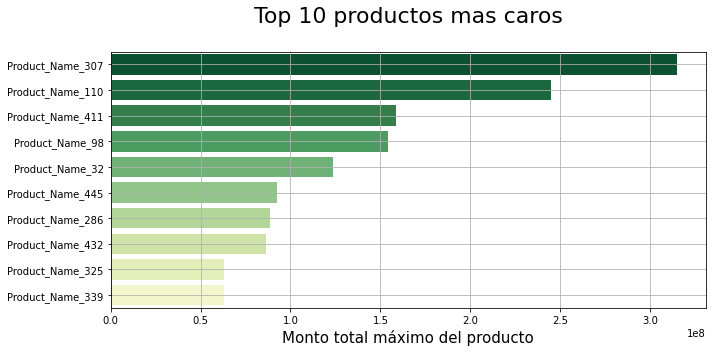

In [195]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_product_amount_max_show,x='Monto Total Maximo',y='Product_Name',palette="YlGn_r")
plt.grid(True)
plt.xlabel('Monto total máximo del producto',size=15)
plt.ylabel('')
plt.title('Top 10 productos mas caros\n',size=22)
plt.tight_layout()
#plt.savefig("pngs/Producto-top-ten-max.png")

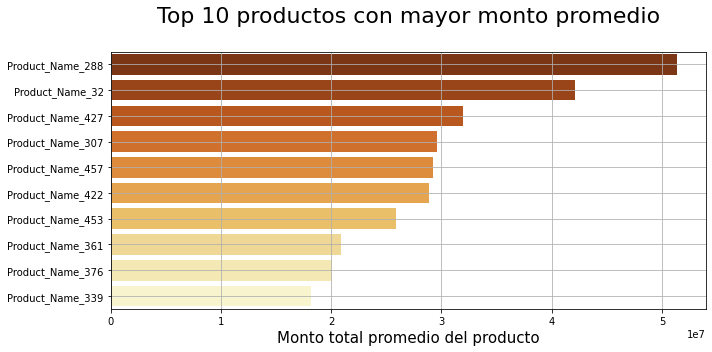

In [196]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=df_product_amount_mean_show,x='Monto Total Promedio',y='Product_Name',palette="YlOrBr_r")
plt.grid(True)
plt.xlabel('Monto total promedio del producto',size=15)
plt.ylabel('')
plt.title('Top 10 productos con mayor monto promedio\n',size=22)
plt.tight_layout()
#plt.savefig("pngs/Producto-top-ten-mean.png")

In [197]:
df_item_amount.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,convertion,Total Item Amount (USD)
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None,1.131096,5964043.80
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None,1.131094,54552.68
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None,1.000000,83865.60
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None,1.000000,7421881.50
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None,1.000000,13357192.50


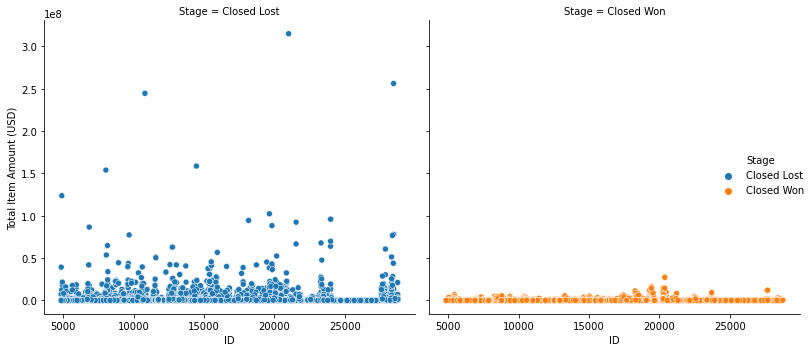

In [198]:
df_item_amount_scatter_1 = df_item_amount.loc[df_item_amount["Stage"].isin(['Closed Won','Closed Lost']),:]

sns.relplot(data=df_item_amount_scatter_1, x='ID', y='Total Item Amount (USD)',hue='Stage',col="Stage",kind="scatter")
plt.tight_layout()
#plt.title('Top 10 productos\n con mayor monto promedio\n',size=22)
#plt.savefig("pngs/Items-montos.png")

In [199]:
df_stage_complete = df.groupby('Opportunity_Name').agg({'Stage': 'last'}).reset_index()
df_stage_complete = df_stage_complete['Stage'].value_counts().to_frame().reset_index()
df_stage_complete["Total"] = df_stage_complete["Stage"].sum()
df_stage_complete["Count/Total"] = df_stage_complete["Stage"] / df_stage_complete["Total"]
df_stage_complete["Percentage"] = df_stage_complete["Count/Total"] * 100
df_stage_complete.columns = ["Stage","Count","Total","Count/Total","Percentage"]
df_stage_complete

,Stage,Count,Total,Count/Total,Percentage
0,Closed Won,5072,9841,0.515395,51.539478
1,Closed Lost,4719,9841,0.479524,47.952444
2,Proposal,30,9841,0.003048,0.304847
3,Negotiation,11,9841,0.001118,0.111777
4,Qualification,9,9841,0.000915,0.091454


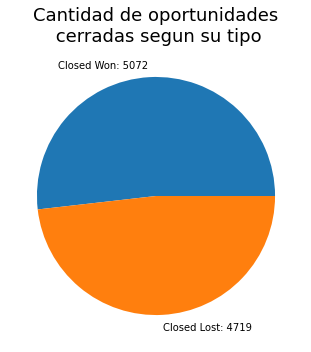

In [200]:
df_stage_closed = df_stage_complete[df_stage_complete["Stage"].str.contains("Closed")].round(2)

fig1,ax1 = plt.subplots(figsize=(5,5))
labels_closed=df_stage_closed['Stage']+": " + (df_stage_closed['Count']).astype(str)
explode_closed = (0, 0)
colors = [] #podemos cambiar los colores
ax1.pie(df_stage_closed['Count'],labels=labels_closed,explode=explode_closed)
plt.title('Cantidad de oportunidades\n cerradas segun su tipo',size=18)
plt.tight_layout()
#plt.savefig("pngs/Oportunidades-closed-cantidad.png")
plt.show()

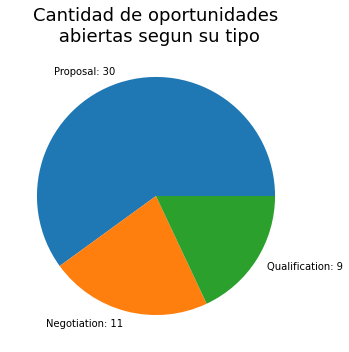

In [201]:
df_stage_open = df_stage_complete[df_stage_complete["Stage"].str.contains("Closed") != True].round(2)

fig2,ax2 = plt.subplots(figsize=(5,5))
labels_open=df_stage_open['Stage']+": " + (df_stage_open['Count']).astype(str)
explode_open = (0, 0, 0)
ax2.pie(df_stage_open['Count'],labels=labels_open,explode=explode_open)
plt.title('Cantidad de oportunidades\n abiertas segun su tipo',size=18)
plt.tight_layout()
#plt.savefig("pngs/Oportunidades-open-cantidad.png")
plt.show()

In [202]:
df_item_amount_closed = df_item_amount.loc[df_item_amount["Stage"].str.contains("Closed"),["ID","Stage","Product_Name","Total Item Amount (USD)"]]
df_item_amount_closed = df_item_amount_closed.dropna().sort_values("Total Item Amount (USD)")
df_item_amount_closed = df_item_amount_closed.groupby(["Total Item Amount (USD)","Stage"]).agg({"ID":"count"}).unstack()
df_item_amount_closed.columns = ["Closed Lost Count","Closed Won Count"]
df_item_amount_closed = (df_item_amount_closed.divide(df_item_amount_closed.sum(axis=1), axis=0) * 100).fillna(0)
df_item_amount_closed

,Closed Lost Count,Closed Won Count
Total Item Amount (USD),,
0.000000e+00,93.939394,6.060606
1.000000e-02,14.285714,85.714286
2.000000e-02,100.000000,0.000000
4.000000e-02,100.000000,0.000000
1.000000e-01,100.000000,0.000000
...,...,...
1.539788e+08,100.000000,0.000000
1.587382e+08,100.000000,0.000000
2.445877e+08,100.000000,0.000000


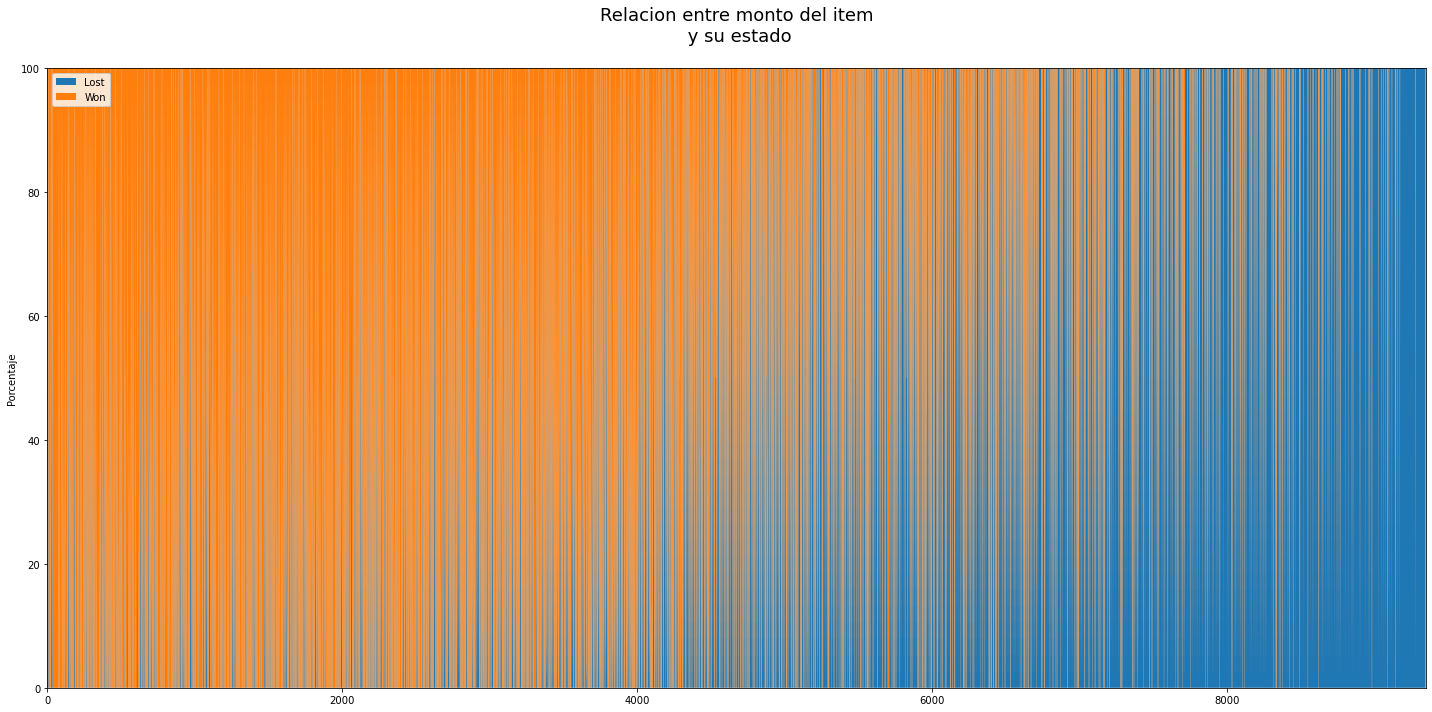

In [203]:
rows = len(df_item_amount_closed.index + 1)
plt.stackplot(range(0,rows),  df_item_amount_closed["Closed Lost Count"],  df_item_amount_closed["Closed Won Count"], labels=['Lost','Won'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Relacion entre monto del item\n y su estado\n',size=18)
plt.ylabel('Porcentaje')
plt.tight_layout()
#plt.savefig("pngs/Relacion-estado-item-monto.png")
plt.show()

In [204]:
df_product_amount = df_item_amount.loc[df_item_amount["Stage"].str.contains("Closed"),["ID","Stage","Product_Name","Product_Family","Total Item Amount (USD)"]]
df_product_amount_show = df_product_amount.groupby(["Product_Name","Product_Family"]).agg({"Total Item Amount (USD)":["mean","max","min","count"]}).dropna().reset_index()
df_product_amount_show

Product_Name     Product_Family Total Item Amount (USD)  \
                                                            mean   
0    Product_Name_100  Product_Family_77            6.682535e+04   
1    Product_Name_101  Product_Family_83            1.251900e+04   
2    Product_Name_102  Product_Family_84            4.128429e+03   
3    Product_Name_103  Product_Family_82            1.920161e+04   
4    Product_Name_104  Product_Family_86            5.327605e+03   
..                ...                ...                     ...   
406   Product_Name_95  Product_Family_80            3.901365e+04   
407   Product_Name_96  Product_Family_77            4.399920e+05   
408   Product_Name_97  Product_Family_77            1.067773e+06   
409   Product_Name_98  Product_Family_77            1.556375e+07   
410   Product_Name_99  Product_Family_77            2.737123e+06   

                                     
              max         min count  
0    1.219400e+07        0.00   963  
1    2.873000e+04      546.00     4  
2    1.878500e+04      132.60    14  
3    3.805459e+04     1852.50     8  
4    2.650000e+04       39.75     6  
..            ...         ...   ...  
406  4.001400e+04    38013.30     2  
407  8.670999e+05   181588.68   135  
408  1.552762e+06        0.00    47  
409  1.539788e+08  5762640.00    41  
410  5.964044e+06   929994.00   123  

[411 rows x 6 columns]

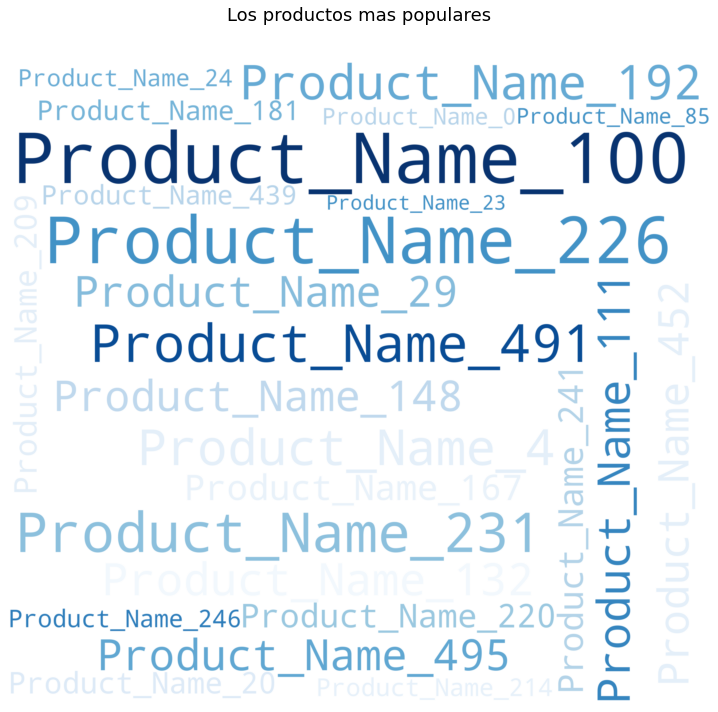

In [205]:
wc= WordCloud(background_color="white",collocations=False, width=3000, height=2800, max_words=25,colormap="Blues")
wordcloud = wc.generate(' '.join(df['Product_Name']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Los productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
#plt.savefig("pngs/item-populares.png")
plt.show()

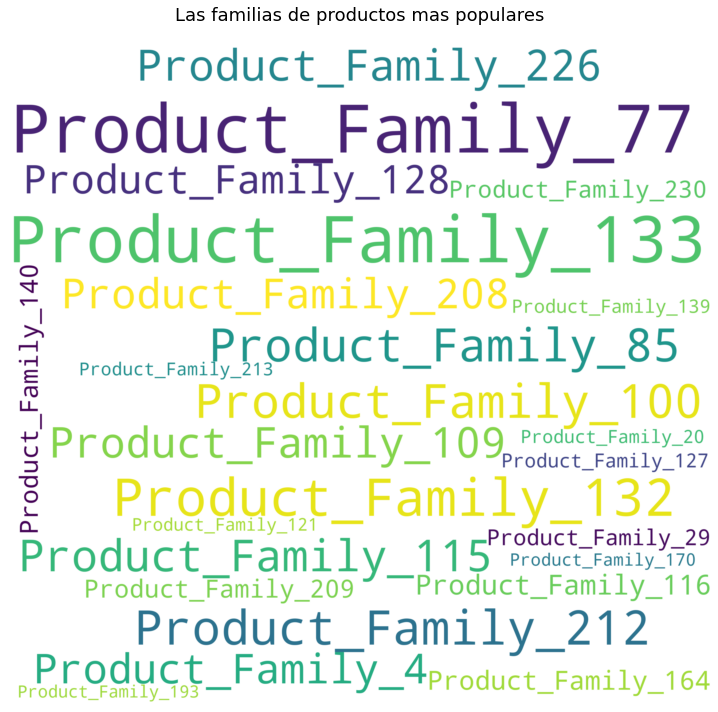

In [206]:
wc= WordCloud(background_color="white",collocations=False, width=3000, height=2800, max_words=25)
wordcloud = wc.generate(' '.join(df['Product_Family']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Las familias de productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
#plt.savefig("pngs/item-familia-populares.png")
plt.show()


In [207]:
df_product_amount.groupby("Product_Family").agg({"Total Item Amount (USD)":"mean","Stage":"count"}).dropna()\
.reset_index().nlargest(5,"Total Item Amount (USD)")

,Product_Family,Total Item Amount (USD),Stage
48,Product_Family_159,5.138560e+07,1
125,Product_Family_32,4.210010e+07,5
99,Product_Family_214,1.944320e+07,4
96,Product_Family_211,1.258040e+07,4
103,Product_Family_221,1.123515e+07,1


In [208]:
df_family_product = df.loc[:,["ID","Product_Family","Product_Name"]].groupby(["Product_Family","Product_Name"]).agg({"ID":"count"}).reset_index().rename(columns={"ID":"Count"})
df_family_product_ten = df_family_product.nlargest(10,"Count")
df_family_product_pivot = df_family_product_ten.pivot("Product_Family", "Product_Name", "Count").fillna(0)
df_family_product_pivot

Product_Name,Product_Name_100,Product_Name_111,Product_Name_132,Product_Name_192,Product_Name_226,Product_Name_231,Product_Name_29,Product_Name_4,Product_Name_491,Product_Name_495
Product_Family,,,,,,,,,,
Product_Family_100,0.0,0.0,383.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Product_Family_115,0.0,0.0,0.0,442.0,0.0,0.0,0.0,0.0,0.0,0.0
Product_Family_132,0.0,0.0,0.0,0.0,0.0,579.0,0.0,0.0,0.0,0.0
Product_Family_133,0.0,0.0,0.0,0.0,836.0,0.0,0.0,0.0,0.0,0.0
Product_Family_226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,524.0,0.0
Product_Family_230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0
Product_Family_29,0.0,0.0,0.0,0.0,0.0,0.0,345.0,0.0,0.0,0.0
Product_Family_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,474.0,0.0,0.0
Product_Family_77,976.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


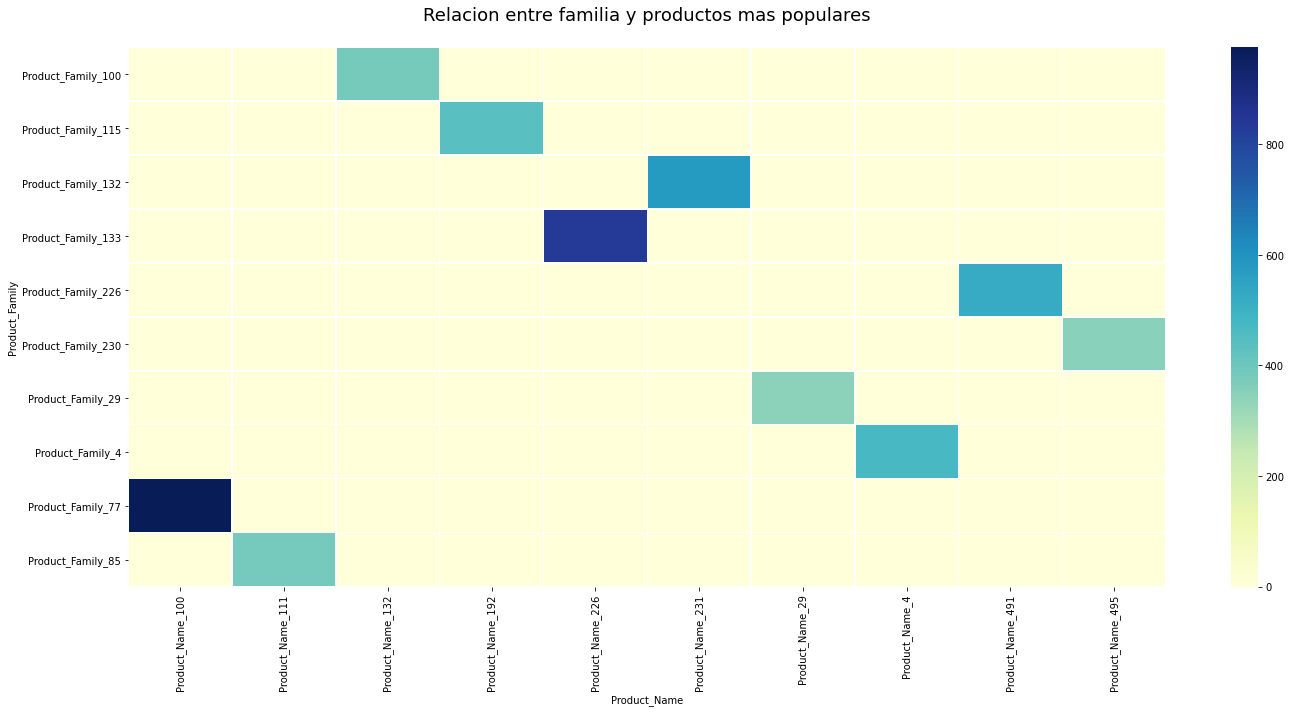

In [209]:
sns.heatmap(df_family_product_pivot,cmap="YlGnBu",linewidths=.5)
plt.title('Relacion entre familia y productos mas populares\n',size=18)
plt.margins(0,0)
plt.tight_layout()
#plt.savefig("pngs/item-familia-populares.png")
plt.show()

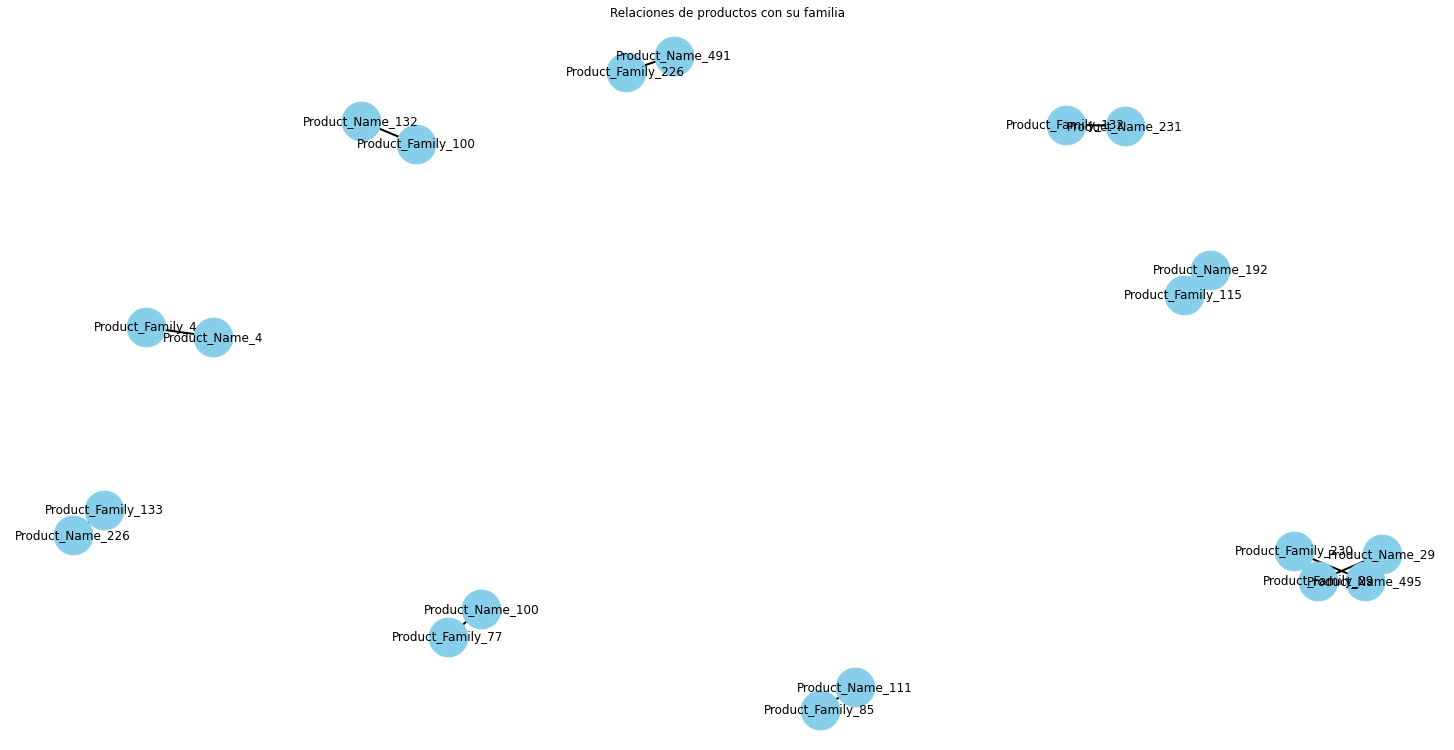

In [210]:
# Build your graph
G=nx.from_pandas_edgelist(df_family_product_ten, 'Product_Name', 'Product_Family')
nx.draw(G, with_labels=True, node_size=1500, node_color="skyblue", pos=nx.spring_layout(G), width=2)
plt.title("Relaciones de productos con su familia")
plt.show()

In [211]:
df_family_product_2= df_family_product.nlargest(20,"Count")
df_family_product_2.head()

,Product_Family,Product_Name,Count
412,Product_Family_77,Product_Name_100,976
104,Product_Family_133,Product_Name_226,836
99,Product_Family_132,Product_Name_231,579
321,Product_Family_226,Product_Name_491,524
362,Product_Family_4,Product_Name_4,474


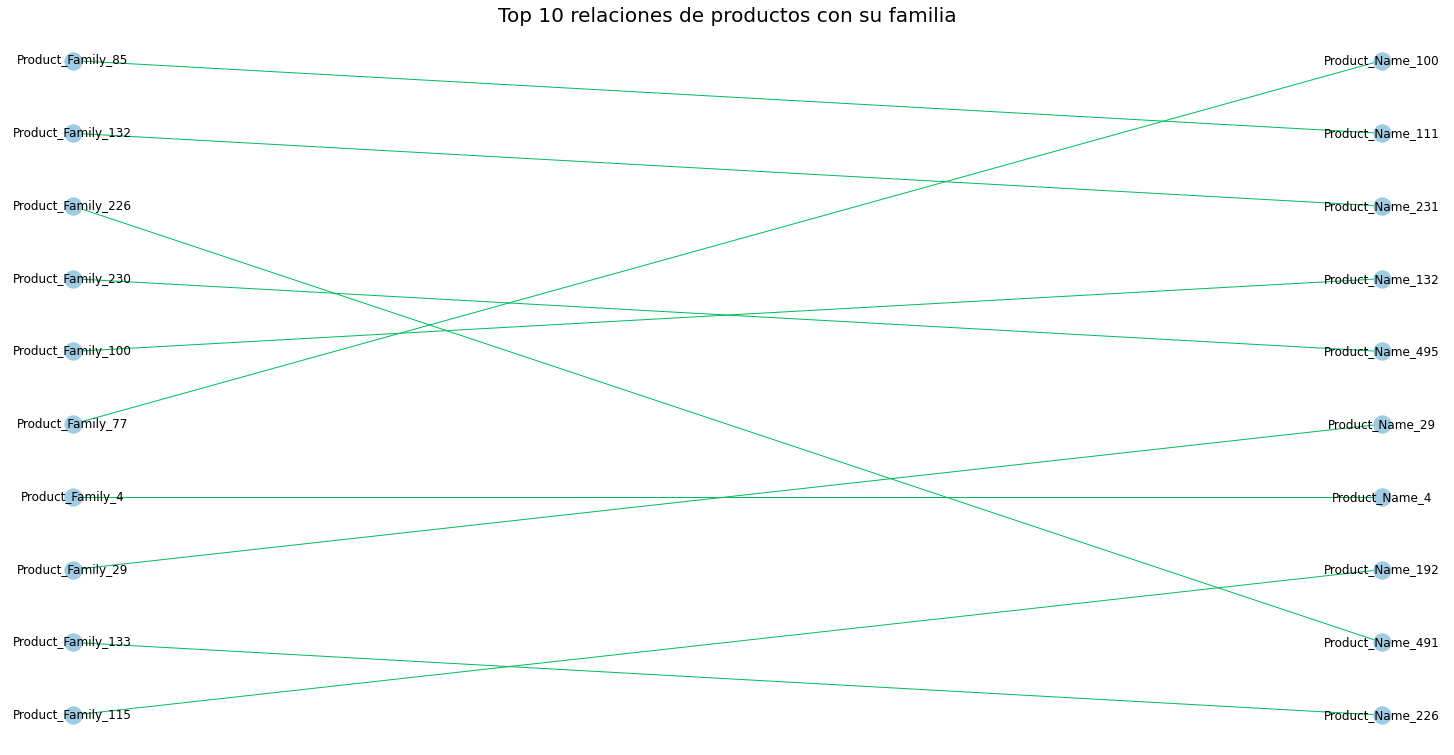

In [212]:
edges = [tuple(x) for x in df_family_product_ten[['Product_Family','Product_Name']].values.tolist()]
B = nx.Graph()
B.add_nodes_from(df_family_product_ten['Product_Family'].unique(), bipartite=0, label='family')
B.add_nodes_from(df_family_product_ten['Product_Name'].unique(), bipartite=1, label='name')
B.add_edges_from(edges, label='Count')

# Now instead of spring_layout, use bipartite_layout

# First specify the nodes you want on left or top
left_or_top = df_family_product_ten['Product_Family'].unique()

# Then create a bipartite layout
pos = nx.bipartite_layout(B, left_or_top)

# Pass that layout to nx.draw
nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,
     edge_cmap=plt.cm.Blues,with_labels=True)

plt.title("Top 10 relaciones de productos con su familia",size=20)
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

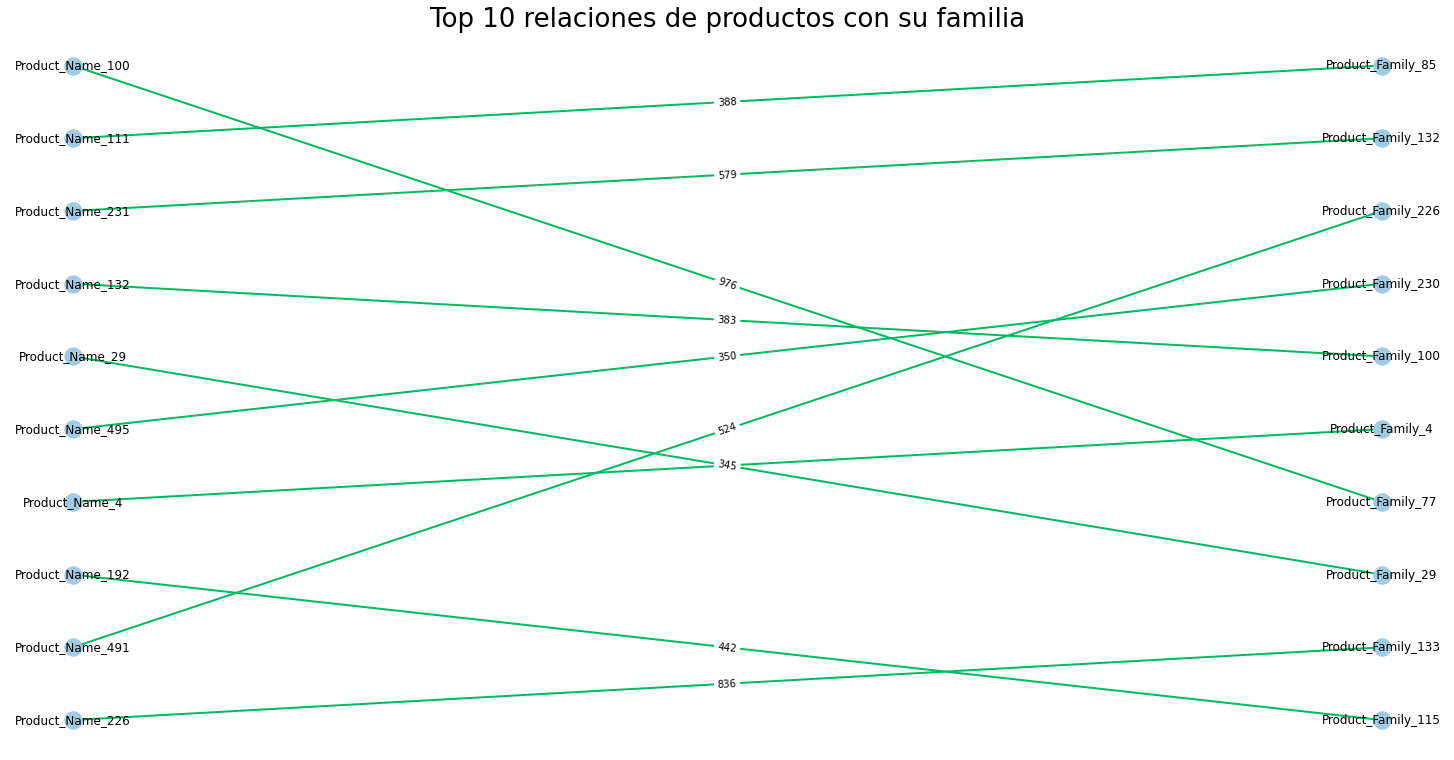

In [213]:
edges = [tuple(x) for x in df_family_product_ten[['Product_Name','Product_Family', 'Count']].values.tolist()]

B = nx.Graph()

B.add_nodes_from(df_family_product_ten['Product_Name'].unique(), bipartite=0, label='name')
B.add_nodes_from(df_family_product_ten['Product_Family'].unique(), bipartite=1, label='family')


# Now assign the ratings correctly to edges
for row in edges:
    B.add_edge(row[0], row[1], Count=row[2])
    
left_or_top = df_family_product_ten['Product_Name'].unique()
pos = nx.bipartite_layout(B, left_or_top)

# Draw the graph
nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=2,
     edge_cmap=plt.cm.Blues,with_labels=True)

# Get the edge labels for ratings
edge_labels = nx.get_edge_attributes(B,'Count')

# Draw the edge labels
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels)

plt.rcParams["figure.figsize"] = (20,10)
plt.title("Top 10 relaciones de productos con su familia",size=26)
#plt.savefig("pngs/item-familia-10-grafo-populares.png")
plt.show()

In [214]:
df_family_product_brand = df.loc[df["Brand"] != "None",["ID","Product_Family","Product_Name","Brand"]].groupby(["Product_Family","Product_Name","Brand"]).agg({"ID":"count"}).reset_index().rename(columns={"ID":"Count"})
df_family_product_brand = df_family_product_brand.nlargest(10,"Count")
df_family_product_brand

,Product_Family,Product_Name,Brand,Count
196,Product_Family_140,Product_Name_241,Other,54
147,Product_Family_132,Product_Name_231,Other,41
29,Product_Family_100,Product_Name_132,Other,22
60,Product_Family_109,Product_Name_148,Other,22
315,Product_Family_213,Product_Name_445,Other,22
276,Product_Family_209,Product_Name_432,Other,17
164,Product_Family_133,Product_Name_226,Brand_9,16
90,Product_Family_121,Product_Name_181,Other,14
11,Product_Family_100,Product_Name_128,Other,12
107,Product_Family_127,Product_Name_214,Other,12


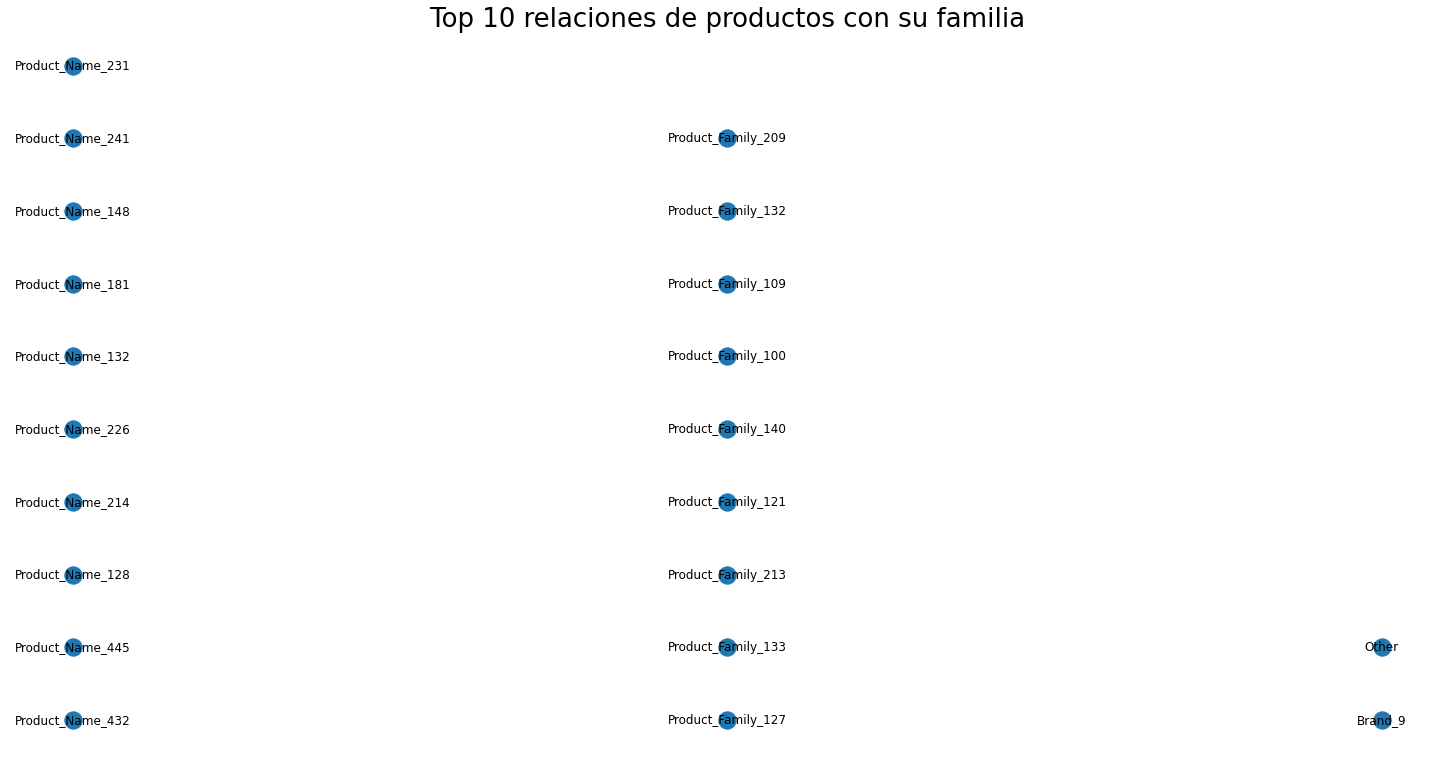

In [215]:
edges = [tuple(x) for x in df_family_product_brand[['Product_Name','Product_Family','Brand','Count']].values.tolist()]

BG = nx.Graph()

BG.add_nodes_from(df_family_product_brand['Product_Name'].unique(), bipartite=0, label='name')
BG.add_nodes_from(df_family_product_brand['Product_Family'].unique(), bipartite=1, label='family')
BG.add_nodes_from(df_family_product_brand['Brand'].unique(), bipartite=2, label='brand')


nodes = BG.nodes()

# for each of the parts create a set 
nodes_0  = set([n for n in nodes if  BG.nodes[n]['bipartite']==0])
nodes_1  = set([n for n in nodes if  BG.nodes[n]['bipartite']==1])
nodes_2  = set([n for n in nodes if  BG.nodes[n]['bipartite']==2])

# set the location of the nodes for each set
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(nodes_0) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(nodes_1) ) # put nodes from Y at x=2
pos.update( (n, (3, i)) for i, n in enumerate(nodes_2) ) # put nodes from X at x=1

nx.draw(BG, pos=pos,with_labels=True)

plt.rcParams["figure.figsize"] = (20,10)
plt.title("Top 10 relaciones de productos con su familia",size=26)
#plt.savefig("pngs/item-familia-10-grafo-populares.png")
plt.show()

In [216]:
df["Region"].value_counts()

Japan          4892
EMEA           4664
Americas       3945
APAC           3262
Middle East     184
Name: Region, dtype: int64

In [217]:
df.groupby("Opportunity_ID").agg({"Opportunity_Name":"count","Region":"first"})["Region"].value_counts()

EMEA           3241
Americas       2459
APAC           2086
Japan          1906
Middle East     149
Name: Region, dtype: int64

In [218]:
df_owner = df.loc[:,["Account_Owner","Opportunity_Owner","Stage","Opportunity_ID"]]
df_owner = df.groupby("Opportunity_ID").agg({"Opportunity_Owner":"first","Account_Owner":"first","Stage":"first"}).reset_index()
df_owner = df_owner.groupby(["Account_Owner","Opportunity_Owner","Stage"]).agg({"Opportunity_ID":"count"}).reset_index().sort_values("Opportunity_ID",ascending=False)
df_owner = df_owner[df_owner["Stage"].str.contains("Closed")]
df_owner_equal = df_owner[df_owner["Account_Owner"] == df_owner["Opportunity_Owner"]]
df_owner_not_equal = df_owner[df_owner["Account_Owner"] != df_owner["Opportunity_Owner"]]

df_owner_equal = df_owner_equal.groupby("Stage").agg({"Opportunity_ID":"sum"}).reset_index()
df_owner_not_equal = df_owner_not_equal.groupby("Stage").agg({"Opportunity_ID":"sum"}).reset_index()
df_owner_equal


,Stage,Opportunity_ID
0,Closed Lost,3826
1,Closed Won,3613


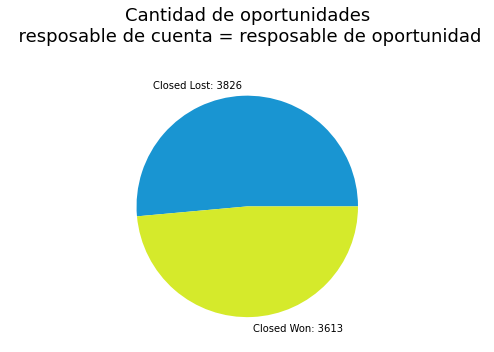

In [219]:

fig1,ax1 = plt.subplots(figsize=(10,5))
labels_closed=df_owner_equal['Stage']+": " + (df_owner_equal['Opportunity_ID']).astype(str)
explode_closed = (0, 0)
colors = ["#1995d2","#d5ea2b"] #podemos cambiar los colores
ax1.pie(df_owner_equal['Opportunity_ID'],labels=labels_closed,explode=explode_closed,colors=colors)
plt.title('Cantidad de oportunidades\n  resposable de cuenta = resposable de oportunidad \n',size=18)
plt.tight_layout()
plt.savefig("pngs/vend-igual.png")
plt.show()

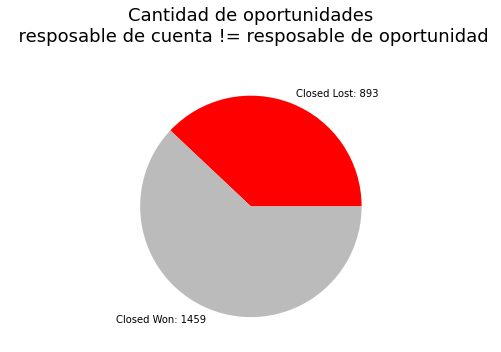

In [220]:
fig1,ax1 = plt.subplots(figsize=(10,5))
labels_closed=df_owner_not_equal['Stage']+": " + (df_owner_not_equal['Opportunity_ID']).astype(str)
explode_closed = (0, 0)
colors = ["#ff0000","#bbbbbb"] #podemos cambiar los colores
ax1.pie(df_owner_not_equal['Opportunity_ID'],labels=labels_closed,explode=explode_closed,colors=colors)
plt.title('Cantidad de oportunidades\n  resposable de cuenta != resposable de oportunidad \n',size=18)
plt.tight_layout()
#plt.savefig("pngs/vend-distinto.png")
plt.show()

In [221]:
#df_owner_won = df.copy()
#df_owner_won = df_owner_won.loc[df_owner_won["Stage"] == "Closed Won",:]
#df_owner_won_heatmap = df_owner_won.pivot("Account_Owner", "Opportunity_Owner", "Opportunity_ID").fillna(0)
#df_owner_won_heatmap
#ax = sns.heatmap(df_owner_won_heatmap.head(20),linewidths=.5,cmap="autumn")

#ax.set_title('Cantidad de oportunidades creadas\n por mes y año\n',size=20)
#ax.set_xlabel('\nAño de creación',size=15)
#ax.set_ylabel('Mes de creación\n',size=15)

#plt.rcParams["figure.figsize"] = (7,7)
#plt.tight_layout()
#plt.savefig("pngs/heatmap-anio-mes.png")
#plt.show()

In [222]:
df["ASP_Currency"].value_counts()

USD    7361
JPY    4522
EUR    4503
AUD     556
GBP       5
Name: ASP_Currency, dtype: int64

In [223]:
# % de aprobación,
# % de exito,
# # de oportunidades
# monto total promedio
# cantidad promedio de frigorias

def stage2binary(x):
  if x.Stage == "Closed Won":
    return 1
  return 0


df_rc = df.copy()
df_rc = df_rc[df_rc['ASP_(converted)'] > 0]
#agrego el valor de conversion a moneda dolar
df_rc["convertion"] = df_rc.apply(conversion, axis=1)
#Convierto el total tax amount a moneda dolar para poder comparar
df_rc["Total Taxable Amount (USD)"] = df_rc["Total_Taxable_Amount"] * df_rc["convertion"]
df_rc.rename(columns = {'Pricing, Delivery_Terms_Approved': 'Aprobado'}, inplace = True)
df_rc['Frigorias'] = df_rc['Total Taxable Amount (USD)'] / df_rc['ASP_(converted)']
df_rc["stage_binary"] = df_rc.apply(stage2binary, axis=1)
df_rc
df_rc = df_rc.groupby("Opportunity_ID").agg({'stage_binary': 'first', \
                                             'Aprobado': 'first', \
                                             'Total Taxable Amount (USD)': 'mean', \
                                             'Frigorias': 'mean', \
                                             'ASP_Currency': 'first',
                                             'Delivery_Quarter': 'first',
                                            'Quote_Type': 'first'}).reset_index()

df_rc


,Opportunity_ID,stage_binary,Aprobado,Total Taxable Amount (USD),Frigorias,ASP_Currency,Delivery_Quarter,Quote_Type
0,0,0,1,5.964044e+06,10140000.0,EUR,Q2,Non Binding
1,1,1,0,5.455268e+04,91000.0,EUR,Q1,Non Binding
2,2,1,0,8.386560e+04,174720.0,USD,Q1,Non Binding
3,3,0,0,7.421882e+06,14003550.0,USD,Q1,Non Binding
4,4,0,0,1.335719e+07,25202250.0,USD,Q1,Non Binding
...,...,...,...,...,...,...,...,...
9673,12799,1,1,4.543578e+05,780000.0,EUR,Q2,Non Binding
9674,12800,0,0,2.133250e+07,40250000.0,USD,Q4,Non Binding
9675,12801,1,1,3.390065e+05,576375.0,EUR,Q1,Non Binding
9676,12802,0,1,0.000000e+00,0.0,USD,Q2,Non Binding


In [224]:
df_rc_2 = df_rc.groupby("ASP_Currency").agg({'stage_binary': 'mean', \
                                     'Opportunity_ID': 'count', \
                                     'Aprobado': 'mean', \
                                     'Total Taxable Amount (USD)': 'mean', \
                                     'Frigorias': 'mean'}).reset_index()
df_rc_2.rename(columns = {
    'stage_binary': 'Porcentaje de exito',
    'Opportunity_ID': 'Cantidad de Oportunidades',
    'Aprobado': 'Porcentaje de aprobacion',
    'Total Taxable Amount (USD)': 'Monto total promedio',
    'Frigorias': 'Promedio de frigorias'
}, inplace=True)
df_rc_2['Porcentaje de exito'] = df_rc_2['Porcentaje de exito']*100
df_rc_2['Porcentaje de aprobacion'] = df_rc_2['Porcentaje de aprobacion']*100
df_rc_2['Promedio de frigorias'] = df_rc_2['Promedio de frigorias'] / df_rc_2['Promedio de frigorias'].sum() * 100
df_rc_2['Monto total promedio'] = df_rc_2['Monto total promedio'] / df_rc_2['Monto total promedio'].sum() * 100
df_rc_2['Cantidad de Oportunidades'] = df_rc_2['Cantidad de Oportunidades'] / df_rc_2['Cantidad de Oportunidades'].sum() * 100
df_rc_2

,ASP_Currency,Porcentaje de exito,Cantidad de Oportunidades,Porcentaje de aprobacion,Monto total promedio,Promedio de frigorias
0,AUD,84.591195,3.285803,77.987421,1.742034,2.157304
1,EUR,47.198970,32.093408,58.016742,9.076391,9.285610
2,GBP,0.000000,0.020665,100.000000,71.950503,69.415248
3,JPY,68.783069,15.623063,67.658730,0.773522,0.825408
4,USD,46.265823,48.977061,47.088608,16.457549,18.316430


In [225]:
from math import pi
def make_spider( row, title, color):
 
    # number of variable
    categories=list(df_rc_2)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2,2,1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([30,60,100], ["30","60","100"], color="black", size=7)
    plt.ylim(0,100)


    values=df_rc_2.loc[row].drop('ASP_Currency').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    plt.title(title, size=11, color=color, y=1.1)

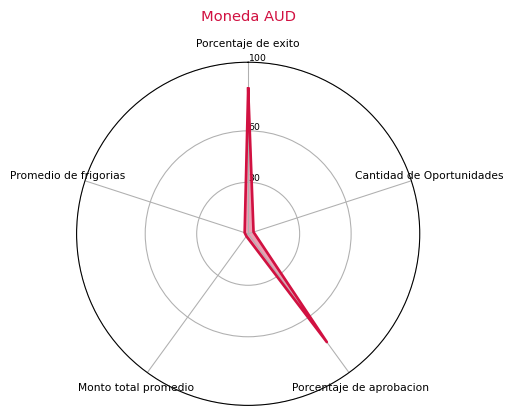

In [226]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=0, title='Moneda '+df_rc_2['ASP_Currency'][0], color='#d11141')

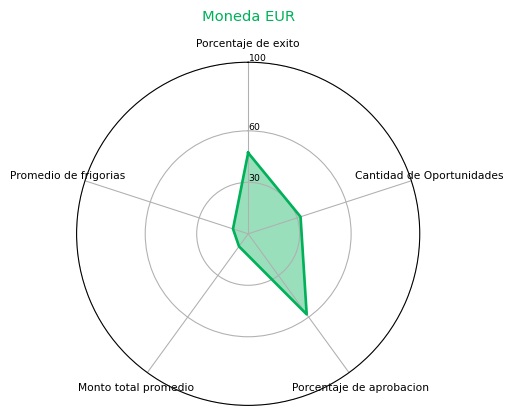

In [227]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=1, title='Moneda '+df_rc_2['ASP_Currency'][1], color='#00b159')

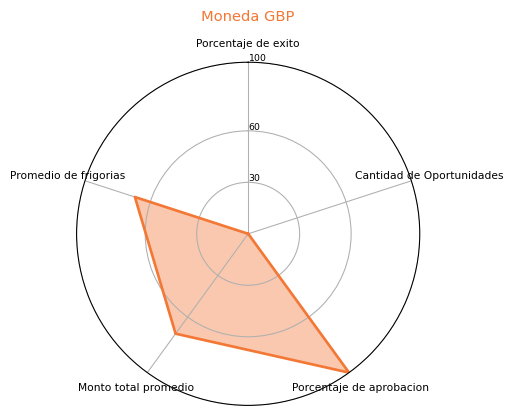

In [228]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=2, title='Moneda '+df_rc_2['ASP_Currency'][2], color='#f37735')

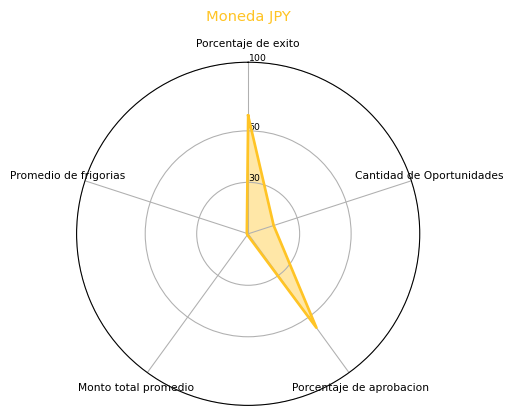

In [229]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=3, title='Moneda '+df_rc_2['ASP_Currency'][3], color='#ffc425')

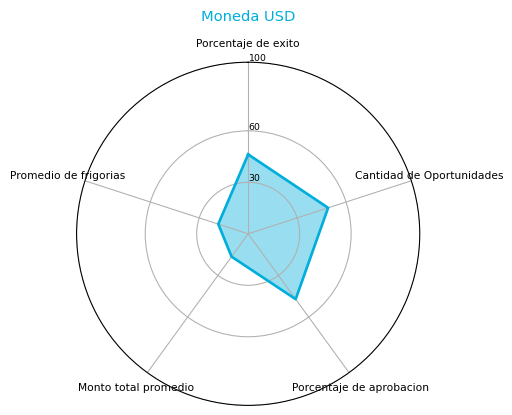

In [230]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider(row=4, title='Moneda '+df_rc_2['ASP_Currency'][4], color='#00aedb')

In [231]:
df_rc_3 = df_rc.groupby("Delivery_Quarter").agg({'stage_binary': 'mean', \
                                     'Opportunity_ID': 'count', \
                                     'Aprobado': 'mean', \
                                     'Total Taxable Amount (USD)': 'mean', \
                                     'Frigorias': 'mean'}).reset_index()
df_rc_3.rename(columns = {
    'stage_binary': 'Porcentaje de exito',
    'Opportunity_ID': 'Cantidad de Oportunidades',
    'Aprobado': 'Porcentaje de aprobacion',
    'Total Taxable Amount (USD)': 'Monto total promedio',
    'Frigorias': 'Promedio de frigorias'
}, inplace=True)
df_rc_3['Porcentaje de exito'] = df_rc_3['Porcentaje de exito']*100
df_rc_3['Porcentaje de aprobacion'] = df_rc_3['Porcentaje de aprobacion']*100
df_rc_3['Promedio de frigorias'] = df_rc_3['Promedio de frigorias'] / df_rc_3['Promedio de frigorias'].sum() * 100
df_rc_3['Monto total promedio'] = df_rc_3['Monto total promedio'] / df_rc_3['Monto total promedio'].sum() * 100
df_rc_3['Cantidad de Oportunidades'] = df_rc_3['Cantidad de Oportunidades'] / df_rc_3['Cantidad de Oportunidades'].sum() * 100
df_rc_3

,Delivery_Quarter,Porcentaje de exito,Cantidad de Oportunidades,Porcentaje de aprobacion,Monto total promedio,Promedio de frigorias
0,Q1,48.697138,24.188882,52.157198,26.265894,26.892383
1,Q2,51.465662,24.674520,59.003350,28.368508,25.882698
2,Q3,49.125729,24.819178,52.331391,25.763454,25.968401
3,Q4,55.712603,26.317421,55.751865,19.602145,21.256519


In [232]:
from math import pi
def make_spider_3( row, title, color):
 
    # number of variable
    categories=list(df_rc_3)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2,2,1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([30,60,100], ["30","60","100"], color="black", size=7)
    plt.ylim(0,100)


    values=df_rc_3.loc[row].drop('Delivery_Quarter').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    plt.title(title, size=11, color=color, y=1.1)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



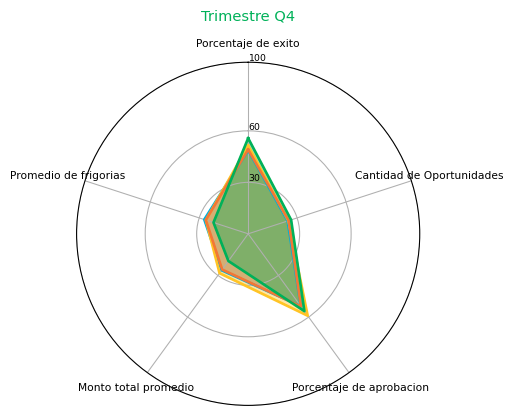

In [233]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider_3(row=0, title='Trimestre '+df_rc_3['Delivery_Quarter'][0], color='#00aedb')
make_spider_3(row=1, title='Trimestre '+df_rc_3['Delivery_Quarter'][1], color='#ffc425')
make_spider_3(row=2, title='Trimestre '+df_rc_3['Delivery_Quarter'][2], color='#f37735')
make_spider_3(row=3, title='Trimestre '+df_rc_3['Delivery_Quarter'][3], color='#00b159')


In [234]:
df_rc_4 = df_rc.groupby("Quote_Type").agg({'stage_binary': 'mean', \
                                     'Opportunity_ID': 'count', \
                                     'Aprobado': 'mean', \
                                     'Total Taxable Amount (USD)': 'mean', \
                                     'Frigorias': 'mean'}).reset_index()
df_rc_4.rename(columns = {
    'stage_binary': 'Porcentaje de exito',
    'Opportunity_ID': 'Cantidad de Oportunidades',
    'Aprobado': 'Porcentaje de aprobacion',
    'Total Taxable Amount (USD)': 'Monto total promedio',
    'Frigorias': 'Promedio de frigorias'
}, inplace=True)
df_rc_4['Porcentaje de exito'] = df_rc_4['Porcentaje de exito']*100
df_rc_4['Porcentaje de aprobacion'] = df_rc_4['Porcentaje de aprobacion']*100
df_rc_4['Promedio de frigorias'] = df_rc_4['Promedio de frigorias'] / df_rc_4['Promedio de frigorias'].sum() * 100
df_rc_4['Monto total promedio'] = df_rc_4['Monto total promedio'] / df_rc_4['Monto total promedio'].sum() * 100
df_rc_4['Cantidad de Oportunidades'] = df_rc_4['Cantidad de Oportunidades'] / df_rc_4['Cantidad de Oportunidades'].sum() * 100
df_rc_4

,Quote_Type,Porcentaje de exito,Cantidad de Oportunidades,Porcentaje de aprobacion,Monto total promedio,Promedio de frigorias
0,Binding,50.406504,1.270924,56.910569,67.339845,64.148229
1,Non Binding,51.344846,98.729076,54.809001,32.660155,35.851771


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



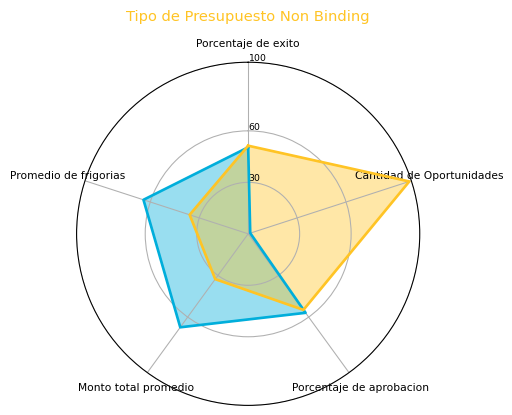

In [236]:
from math import pi
def make_spider_4( row, title, color):
 
    # number of variable
    categories=list(df_rc_4)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(2,2,1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([30,60,100], ["30","60","100"], color="black", size=7)
    plt.ylim(0,100)


    values=df_rc_4.loc[row].drop('Quote_Type').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    plt.title(title, size=11, color=color, y=1.1)
    
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider_4(row=0, title='Tipo de Presupuesto '+df_rc_4['Quote_Type'][0], color='#00aedb')
make_spider_4(row=1, title='Tipo de Presupuesto '+df_rc_4['Quote_Type'][1], color='#ffc425')